# Iterative Backtesting

This implementation helps testing and optimizing SMA strategy with historical binance data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import sys
from itertools import product
from lib.TechnicalIndicators import SMA, EWMA, BollingerBands

### Maintenance Margin
The calculation of maintenance margin is necessary to get the liquidation price of orders.
This class keeps tables of maintenance margin of pairs of instruments. Your need to instantiate it before making orders. If you want to trade a new pair, you need to search its table and add it to the class!!!!

Tables and formula obtained from https://www.binance.com/en/futures/trading-rules/perpetual/leverage-margin

In [2]:
class MaintenanceMarginTables():
    #obtained from https://www.binance.com/en/futures/trading-rules/perpetual/leverage-margin
    
    def __init__(self):
        ### Available Maintenance Margin tables ###
        self.BTCUSDT = None
        self.BTCBUSD = None
        ########### Fill each table ##############
        d = {'Tier': range(1,11),
         'PB' : [50000, 250000, 1000000, 10000000, 20000000, 50000000, 100000000, 200000000, 300000000, 500000000], #Position Bracker (Notional Value in USDT) (top boundary)
         'ML' : [125, 100, 50, 20, 10, 5, 4, 3, 2, 1], #Max Leverage
         'MMR' : [0.004, 0.005, 0.01, 0.025, 0.05, 0.1, 0.125, 0.15, 0.25, 0.5], #Maintenance Margin Rate
         'MA' : [0, 50, 1300, 16300, 266300, 1266300, 2516300, 5016300, 25016300, 100016300] #Maintenance AMount (USDT)
        }
        self.BTCUSDT = pd.DataFrame(data = d)

        d = {'Tier': range(1,11),
         'PB' : [50000, 250000, 1000000, 7500000, 40000000, 100000000, 200000000, 400000000, 600000000, 1000000000], #Position Bracker (Notional Value in BUSD) (top boundary)
         'ML' : [50, 25, 20, 10, 6, 5, 4, 3, 2, 1], #Max Leverage
         'MMR' : [0.004, 0.005, 0.01, 0.025, 0.05, 0.1, 0.125, 0.15, 0.25, 0.5], #Maintenance Margin Rate
         'MA' : [0, 50, 1300, 16300, 203800, 2203800, 4703800, 9703800, 49703800, 199703800] #Maintenance AMount (BUSD)
        }
        self.BTCBUSD = pd.DataFrame(data = d)
        
    def get_table(self, pair):
        table = "self."+ pair.upper()
        return eval(table)
MMT = MaintenanceMarginTables()        

In [3]:
#this is an example of how to retrieve a table and the necessary row with the information.
table = MMT.get_table("BTCBUSD") #get the table 
size = 60658 #size of position (amount bought)
#locate the corresponding row with size
row = table.loc[ size >= table['PB'].shift(1).fillna(0) ].loc[ size < table['PB'] ]
#get all the row values, these are the required to calculate maintenance margin.
tier, pb, ml, mmr, ma = row.values[0]
ma

50.0

In [4]:
#to calculate maintenance margin you should follow the formula:
#Maintenance Margin = Notional Position Value * Maintenance Margin Rate - Maintenance Amount
#Note: notional position value quantity of asset * current mark price =  current size of position
#we use just price instead of mark price for simplicity!!      
mm = size * mmr - ma
mm #maintenance margin

253.29000000000002

In [5]:
# Max leverage depends on how much we want to buy, so be careful!!!
#This is how we calculate the max leverage for a certain total amount that we want to buy
table = MMT.get_table("BTCBUSD") #get the table 
total_amount = 60658 #size of position (amount bought)
max_leverage = table.loc[ total_amount <= table['PB']].ML.iloc[0]
max_leverage

25

### How open position units (buy or sell) are calculated?

When you have leverage, you just want to spend the corresponding fracon of the ammount passed to function. For example, if you have leverage of 3 and you pass amount = 3000, then you just want to spend 1000 for buying or selling. With this in mind we build the next formulas that must hold true...

$$myAmount=TotalAmount/ Leverage$$

$$AmountForUnits + paidFee = myAmount$$

$$paidFee = (totalAmountBought)*Fee = (AmountForUnits*Leverage)*Fee$$

then, 

$$AmountForUnits + AmountForUnits*Leverage*fee = myAmount$$

$$AmountForUnits = myAmount/( 1 + Leverage*fee )$$

With this, you will spend your corresponding fraction of the money buying the correct units and paying the fee entirely.

Important:
 
$$AmountForUnits*Leverage + fee != myAmount*Leverage$$

In other words, you dont use all the amount you pass to the function to buy or sell units, because you have to pay fees with that money. The money you pay for fees increases with leverage. 


### How close position units (buy or sell) are calculated?

When you close a position, you also have to consider leverage, because when do it, it returns to you your units on "amount" and the profit of ALL the position. In other words, you have to return the units to the broker again. Dont forget to pay the comission of closing. We use the next formulas to calculate everything: 

$$Units = UnleveredUnits*Leverage$$
$$myAssetEntryValue = unleveredUnits * entryPrice$$
$$profit = Units * (currentPrice - entryPrice)$$
$$payFee = abs(Units) * currentPrice * Fee$$ 

Then you consider all this to update your current balance:

$$balance += myAssetEntryValue + profit - payFee

Important: for short positions, units are negative, because you sell them, then the formulas have sense.

# Order Class

This class keeps track of each order calculations

In [3]:
class Order():
    
    def __repr__(self):
        if self.position == 1:
            return "LONG"
        else:
            return "SHORT"
    
    def __init__(self, amount, leverage, expected_entry_price, position, created_at, 
                 fee_maker, fee_taker, use_fee, symbol, order_type = "MARKET", verbose = True):
        self.verbose = verbose
        self.symbol = symbol
        self.order_type = order_type
        self.amount = amount
        self.leverage = leverage
        self.amount_to_spend = self.amount/self.leverage #amount to really spend from my balance
        self.expected_entry_price = expected_entry_price
        self.position = position #long (1) or short (-1)
        self.fee_maker = fee_maker #comision for limit order
        self.fee_taker= fee_taker #comision for market order
        self.use_fee = use_fee #True or False
        self.created_at = created_at # creating position datetime
        ########### Open position params ###########
        self.entry_price = None
        self.opening_at = None #opening position datetime
        self.unlev_amount_to_buy_units = None
        self.amount_to_buy_units = None
        self.opening_fee_as_amount = None 
        self.opening_fee_as_units = None
        self.unlev_units = None
        self.units = None
        ########### Close position params ###########
        self.closing_at = None #close position datetime
        self.closing_fee_as_amount = None 
        self.closing_fee_as_units = None
        self.closing_price = None
        self.liquidated = False #Tells if position was liquidated
        self.liquidation_price = None
        
    def open_position(self, date, entry_price):
        self.opening_at = date # open position datetime
        if entry_price is None: 
            self.entry_price = self.expected_entry_price #for limit orders
        else:
            self.entry_price = entry_price #market orders    
        ##################### Works for long and short ##################    
        self.unlev_amount_to_buy_units = self.amount_to_spend/( 1 + self.leverage*self.fee_taker*self.use_fee )
        self.amount_to_buy_units = self.unlev_amount_to_buy_units*self.leverage
        self.opening_fee_as_amount = self.amount_to_buy_units*self.fee_taker*self.use_fee
        self.opening_fee_as_units = self.opening_fee_as_amount/self.entry_price
        self.unlev_units = self.unlev_amount_to_buy_units/self.entry_price
        self.units = self.unlev_units*self.leverage
        if self.position == 1 and self.verbose:
            print("{} |  Buying {} for {}, leverage {}".format(self.opening_at, self.units, round(self.entry_price, 5), self.leverage))
        elif self.verbose:
            print("{} |  Selling {} for {}, leverage {}".format(self.opening_at, self.units, round(self.entry_price, 5), self.leverage))
        return self.units, self.opening_fee_as_amount
        
    def get_close_fee(self, price, as_amount= True):
        #long - pay more comission if price raises
        #short - pay more comission if price falls
        fee = self.units * self.entry_price + self.position * self.units * (price - self.entry_price) 
        fee = fee * self.fee_taker
        if not as_amount: fee/=price #as units
        return fee * self.use_fee
    
    def get_PnL(self, price, include_fee = False, as_amount = True):
        #get profit (by default doesnt include fee as Binance)
        PnL = self.position * self.units * (price - self.entry_price)
        fee = self.get_close_fee(price, as_amount= True) * include_fee
        profit = PnL - fee
        if not as_amount: profit/=price
        return profit
    
    def get_position_value(self, price, include_fee = True, as_amount = True):
        #gets the spent money and profits of the position (subtracts closing fee if True)
        profit = self.get_PnL(price = price, include_fee = include_fee, as_amount = True)
        pos_val = self.unlev_amount_to_buy_units + profit
        if not as_amount: pos_val /= price
        return pos_val
    
    def close_position(self, date, price, liquidate = False):
        self.closing_at = date
        self.closing_price = price
        self.closing_fee_as_amount = self.get_close_fee(price, as_amount = True)
        self.closing_fee_as_units = self.get_close_fee(price, as_amount = False)
        pos_value = self.get_position_value(price)
        if self.position == -1 and self.verbose:
            print("{} |  Buying (closing) {} for {}".format(date, self.units, round(price, 5)))
        elif self.verbose:
            print("{} |  Selling (closing) {} for {}".format(date, self.units, round(price, 5)))  
        return pos_value
    
    def is_open(self):
        return self.closing_at is None
    
    def is_closed(self):
        return not self.is_open()
    
    def get_maintenance_margin(self, price):
        #this is an example of how to retrieve a table and the necessary row with the information.
        if self.symbol.upper() in "BTCUSDT":
            table = MMT.get_table("BTCUSDT") 
        elif self.symbol.upper() in "BTCBUSD":
            table = MMT.get_table("BTCBUSD")
        else:
            table = MMT.get_table(self.symbol)
        size = self.units*price #size of position
        #locate the corresponding row with size
        row = table.loc[ size >= table['PB'].shift(1).fillna(0) ].loc[ size < table['PB'] ]
        #get all the row values, these are the required to calculate maintenance margin.
        tier, pb, ml, mmr, ma = row.values[0]
        mm = size * mmr - ma
        return mm
    
    def calculate_margin_ratio(self, price):
        #when margin ratio == 1, that is the liquidation price
        maintenance_margin = self.get_maintenance_margin(price)
        balance = self.unlev_amount_to_buy_units #just for isolated mode (for cross you must use wallet)
        quantity = self.units
        mark_price = price #for simplicity
        entry_price = self.entry_price
        
        margin_ratio = maintenance_margin/( balance + self.position* quantity * ( mark_price - entry_price ))
        return margin_ratio
    
    def get_liquidation_price(self):
        #uses price instead of mark_price for simplicity
        #the liquidation price changes to farther when mark price gets close, so we  
        #execute this function many times to get close to the real one!!!!
        if self.liquidation_price is not None: return self.liquidation_price
        mark_price = self.entry_price
        pos = self.position
        entry_price = self.entry_price
        balance = self.unlev_amount_to_buy_units #just for isolated mode (for cross you must use wallet)
        quantity = self.units
        precision = 5 #more precision == closer you get to real liquidation price
        for i in range(precision):
            maintenance_margin = self.get_maintenance_margin(mark_price)
            liquidation_price = pos*( maintenance_margin - balance )/quantity + entry_price
            mark_price = liquidation_price
        self.liquidation_price = liquidation_price 
        return self.liquidation_price
    
    def should_liquidate(self, price): 
        if self.position == 1 and price <= self.get_liquidation_price():
            return True
        elif self.position == -1 and price >= self.get_liquidation_price():
            return True
        else:
            return False
    
    def liquidate_position(self, date):
        self.closing_at = date
        self.closing_price = self.liquidation_price
        self.liquidated = True
        if self.position == -1 and self.verbose:
            print("{} |  Buying (liquidating) {} for {}".format(date, self.units, round(self.closing_price, 5)))
        elif self.verbose:
            print("{} |  Selling (liquidating) {} for {}".format(date, self.units, round(self.closing_price, 5))) 

## How to use orders

In [4]:
#initialize the order
from datetime import datetime

leverage = 10
#initialize the order (it makes sense with limit orders because its like submit them)
order = Order(amount = 60522.84*leverage, #more info of this on sections above
              leverage = leverage, 
              expected_entry_price = 60522.84, #useful for limit orders, price when order is executed 
              position = 1, #1 for long, -1 for short
              created_at = datetime.now(), #datetime when order is created        
              fee_maker = 0.0002, 
              fee_taker = 0.0004, 
              use_fee = True,
              symbol = "BTCUSD")
#execute the order 
#with market orders we use entry_price = expected_entry_price to simulate execution at the moment
order.open_position(datetime.now(), entry_price = order.expected_entry_price)

2022-12-07 22:19:43.713364 |  Buying 9.960159362549799 for 60522.84, leverage 10


(9.960159362549799, 241.12685258964137)

In [8]:
#get closing fee of position at a certain price
order.get_close_fee(price = 50522, as_amount = True)

201.28286852589636

In [9]:
#prints current PnL of position at a certain price
order.get_PnL(price = 50000, as_amount = True, include_fee = True)

-105008.3665338645

In [10]:
#returns all money that you will receive if position is closed (including invested one) at a certain price
order.get_position_value(price = 50000, as_amount = True, include_fee = True)

-44726.65338645415

In [11]:
#True if position is open
order.is_open()

True

In [12]:
#closes the position and returns profits at a certain price...
pos_val = order.close_position(datetime.now(), price = 50000)

2022-12-04 13:11:26.755591 |  Selling (closing) 9.960159362549799 for 50000


In [13]:
#True if position is closed
order.is_closed()

True

¡¡This is useful for test with binance!!

In [61]:
#initialize the order
from datetime import datetime

leverage = 50
#initialize the order (it makes sense with limit orders because its like submit them)
order = Order(amount = 995.7, #more info of this on sections above
              leverage = leverage, 
              expected_entry_price = 16875, #useful for limit orders, price when order is executed 
              position = -1, #1 for long, -1 for short
              created_at = datetime.now(), #datetime when order is created        
              fee_maker = 0.0002, 
              fee_taker = 0.0004, 
              use_fee = True,
              symbol = "BTCUSD")
#execute the order 
#with market orders we use entry_price = expected_entry_price to simulate execution at the moment
order.open_position(datetime.now(), entry_price = order.expected_entry_price)

2022-12-07 23:39:28.910062 |  Selling 0.057847494553376906 for 16875, leverage 50


(0.057847494553376906, 0.3904705882352941)

In [62]:
order.opening_fee_as_amount

0.3904705882352941

In [63]:
close_price = 16934
order.get_close_fee(price = close_price, as_amount = True)

0.38910538736383443

In [64]:
order.get_PnL(price = close_price, as_amount = True, include_fee = False)

-3.4130021786492373

In [65]:
profit = order.get_PnL(price = close_price, as_amount = True, include_fee = False) - order.opening_fee_as_amount- order.get_close_fee(price = close_price, as_amount = True)
profit

-4.192578154248365

In [66]:
2242.73 + profit

2238.537421845752

In [56]:
order.close_position(datetime.now(), close_price)

2022-12-07 23:26:36.452192 |  Buying (closing) 0.057847494553376906 for 16934


15.721421845751633

In [69]:
order.amount_to_spend

19.914

### Calculating liquidation price of an order
This example can give same results as lecture:

https://www.udemy.com/course/cryptocurrency-algorithmic-trading-with-python-and-binance/learn/lecture/29496642?start=660#overview

If you want to reproduce the results of lecture, you have to hardcode balance to given on lecture on functions

The formulas of liquidation price also can be found there.

In [14]:
#initialize the order
from datetime import datetime

leverage = 20
#initialize the order (it makes sense with limit orders because its like submit them)
order = Order(amount = 5000000, #more info of this on sections above
              leverage = leverage, 
              expected_entry_price = 19943.0, #useful for limit orders, price when order is executed 
              position = 1, #1 for long, -1 for short
              created_at = datetime.now(), #datetime when order is created        
              fee_maker = 0.0002, 
              fee_taker = 0.0004, 
              use_fee = False,
              symbol = "BTCUSD")
#execute the order 
#with market orders we use entry_price = expected_entry_price to simulate execution at the moment
order.open_position(datetime.now(), entry_price = order.expected_entry_price)

2022-12-04 13:11:27.349396 |  Buying 250.71453642882216 for 19943.0, leverage 20


(250.71453642882216, 0.0)

In [15]:
#use to retrieve the liquidation price of the order!!!
liq_price = order.get_liquidation_price()
liq_price

19364.95982102954

In [16]:
#you can verify if is the liquidation price if margin ratio is close to 1 for that number
order.calculate_margin_ratio(liq_price) 

0.999999986867876

In [17]:
#Returns true or false, tells just if should liquidate
order.should_liquidate(liq_price)

True

In [18]:
#PnL is not -100% on liquidation price, because binance liquidates before reaching the deadline.
#Thats why is recommended to do a Stop Loss near liquidation price. You can save a lot of money doing that.
order.get_PnL(price = 19931, as_amount = True, include_fee = True)

-3008.574437145866

In [19]:
#liquidate a position at a certain time, it closes the position and mark it as liquidated
order = order.liquidate_position(date = datetime.now())

2022-12-04 13:11:28.647347 |  Selling (liquidating) 250.71453642882216 for 19364.95982


# BinanceApi Class
This class helps to keep track of actions made in "account".

In [20]:
class BinanceApi():

    def __init__(self, symbol, start, end, amount, use_fee = True, fee_maker=0, fee_taker=0,
                 verbose = True, csv = "data/5m.csv"):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.csv = csv #csv to use
        self.initial_balance = amount
        self.available_balance = amount #keeps unlevered balance (real balance)
        self.open_orders = [] #stores open orders
        self.closed_orders= [] #stores closed orders
        self.PnLs = []
        self.liquidated_orders = 0 #stores count of liquidated orders
        self.trades = 0
        self.paid_fees = 0 #accumulates paid fees
        self.use_fee = use_fee
        self.fee_maker = fee_maker #limit orders fee
        self.fee_taker = fee_taker #market orders fee (higher)
        self.leverage = 1
        self.get_data()
        self.verbose = verbose
    def get_data(self):
        raw = pd.read_csv(self.csv, parse_dates = ["Date"], index_col = "Date").dropna()
        raw = raw.loc[self.start:self.end]
        raw = raw[["Close"]].rename(columns={"Close": "price"}) #just use these columns
        raw["returns"] = np.log(raw.price / raw.price.shift(1))
        raw["Hold Strategy"] = raw["returns"].cumsum().apply(np.exp) * self.initial_balance
        self.data = raw

    def plot_data(self, cols = None):  
        if cols is None:
            cols = "price"
        self.data[cols].plot(figsize = (12, 8), title = self.symbol)
    
    def get_values(self, bar):
        date = str(self.data.index[bar].date())
        price = round(self.data.price.iloc[bar], 5)
        return date, price
    
    def print_available_balance(self, bar):
        date, price = self.get_values(bar)
        print("{} | Current Balance: {}".format(date, round(self.available_balance, 2)))
        
    def buy_instrument(self, bar, units = None, amount = None):
        date, price = self.get_values(bar)
        
        if self.get_position() in [0]: #open long position
            if amount is None: amount = units*price
            order = Order(amount = amount, 
              leverage = self.leverage, 
              expected_entry_price = price,
              position = 1, 
              created_at = date,       
              fee_maker = self.fee_maker, 
              fee_taker = self.fee_taker, 
              use_fee = self.use_fee,
              symbol = self.symbol,
              verbose = self.verbose)
            if order.amount_to_spend > self.available_balance+0.1: #avoids floating errors
                self.not_enough_balance(order.amount_to_spend, self.available_balance)
                return #dont continue with operation!
            order.open_position(date = date, entry_price = price)
            self.paid_fees += order.opening_fee_as_amount
            self.open_orders.append(order)
            self.available_balance -= order.amount_to_spend
            self.trades += 1
        elif self.get_position() in [-1]: #closing short position
            order = self.open_orders[0]
            pos_value = order.close_position(date = date, price = price)
            self.paid_fees += order.closing_fee_as_amount
            self.available_balance += pos_value
            self.open_orders = []
            self.closed_orders.append(order)
            self.PnLs.append(order.get_PnL(price = price, include_fee = True)- order.opening_fee_as_amount)
                    
    def sell_instrument(self, bar, units = None, amount = None):
        date, price = self.get_values(bar)
        
        if self.get_position() in [0]: #open short position
            if amount is None: amount = units*price
            order = Order(amount = amount, 
              leverage = self.leverage, 
              expected_entry_price = price,
              position = -1, 
              created_at = date,       
              fee_maker = self.fee_maker, 
              fee_taker = self.fee_taker, 
              use_fee = self.use_fee,
              symbol = self.symbol,
              verbose = self.verbose)
            if order.amount_to_spend > self.available_balance+0.1: #avoids floating errors
                self.not_enough_balance(order.amount_to_spend, self.available_balance)
                return #dont continue with operation!
            order.open_position(date = date, entry_price = price)
            self.paid_fees += order.opening_fee_as_amount
            self.open_orders.append(order)
            self.available_balance -= order.amount_to_spend
            self.trades += 1
        elif self.get_position() in [1]: #closing long position
            order = self.open_orders[0]
            pos_value = order.close_position(date = date, price = price)
            self.paid_fees += order.closing_fee_as_amount
            self.available_balance += pos_value
            self.open_orders = []
            self.closed_orders.append(order)
            self.PnLs.append(order.get_PnL(price = price, include_fee = True)- order.opening_fee_as_amount)
            
    def print_current_nav(self, bar):
        nav = self.get_nav(bar)
        print("{} |  Net Asset Value = {}".format(date, round(nav, 2)))
        
    def get_nav(self, bar):
        if len(self.open_orders) == 0: return self.available_balance
        date, price = self.get_values(bar)
        order = self.open_orders[0]
        pos_value = order.get_position_value(price = price, include_fee = True, as_amount = True)
        return self.available_balance + pos_value

    def get_position(self):
        if len(self.open_orders) == 0:
            return 0
        return self.open_orders[0].position
    
    def verify_not_liquidation(self, bar):
        date, price = self.get_values(bar)
        if self.get_position() == 0: return #currently no open positions
        order = self.open_orders[0]
        if order.should_liquidate(price):
            order.liquidate_position(date = date)
            self.open_orders = []
            self.closed_orders.append(order)
            self.liquidated_orders += 1
    def not_enough_balance(self,need, have):
        print("You dont have necessary balance to open this order!: cost:{}, balance:{}".format(
                    round(need,2), round(have,2)
                ))
    def get_max_order_leverage(self, total_amount):
        if self.symbol.upper() in "BTCUSDT":
            table = MMT.get_table("BTCUSDT") 
        elif self.symbol.upper() in "BTCBUSD":
            table = MMT.get_table("BTCBUSD")
        else:
            table = MMT.get_table(self.symbol)
        max_leverage = table.loc[ total_amount <= table['PB']].ML.iloc[0]
        return max_leverage
    def get_max_order_amount(self, leverage):
        if self.symbol.upper() in "BTCUSDT":
            table = MMT.get_table("BTCUSDT") 
        elif self.symbol.upper() in "BTCBUSD":
            table = MMT.get_table("BTCBUSD")
        else:
            table = MMT.get_table(self.symbol)
        max_total_amount = table.loc[ leverage <= table['ML']].PB.iloc[-1]
        return max_total_amount
    def validate_order_amount(self, desired_amount, leverage):
        #returns a valid amount to spend with a certain leverage
        max_amount_with_lev = self.get_max_order_amount(leverage)
        max_amount_with_balance = self.available_balance*self.leverage
        amount = min(max_amount_with_lev, max_amount_with_balance, desired_amount) #respect leverage and balance restrictions!!
        if self.verbose and desired_amount != amount: print("Invalid amount for order, changing to a valid one...")
        return amount
    def change_leverage(self, new_leverage):
        current_position = self.get_position()
        if current_position: 
            print("cant change leverage with open position")
            return -1
        self.leverage = new_leverage
        return self.leverage

# Backtest class
keeps strategies for automated trading

In [22]:
class IterativeBacktest(BinanceApi):
    
    #def __init__(self):
    #    self.strategies = [] #keeps all the strategies used
    #    self.predicted_pos = 0 #keeps current predicted position of strategies
    #    self.ind_sum = 0 #keeps current indicators sum for predicted positions
        
    # helper method
    def go_long(self, bar, units = None, amount = None, prc = False):
        if self.get_position() != 0:
            self.go_neutral(bar) #if some position, go neutral first
        if self.should_end_session(): return
        self.leverage_strategy(ind_sum = self.ind_sum, ind_count = len(self.strategies))
        if units:
            self.buy_instrument(bar, units = units)
        elif amount:
            if amount == "all":
                amount = self.available_balance * self.leverage
            if prc: 
                amount = (self.available_balance * amount/100) * self.leverage    
            amount = self.validate_order_amount(amount, self.leverage)
            self.buy_instrument(bar, amount = amount) # go long

    # helper method
    def go_short(self, bar, units = None, amount = None, prc = False):
        if self.get_position() != 0:
            self.go_neutral(bar) # if some position, go neutral first
        if self.should_end_session(): return
        self.leverage_strategy(ind_sum = self.ind_sum, ind_count = len(self.strategies))
        if units:
            self.sell_instrument(bar, units = units)
        elif amount:
            if amount == "all":
                amount = self.available_balance*0.95 * self.leverage
            if prc: 
                amount = (self.available_balance * amount/100) * self.leverage      
            amount = self.validate_order_amount(amount, self.leverage)
            self.sell_instrument(bar, amount = amount) # go short
    
    def go_neutral(self, bar):
        if self.get_position() == 1: #if long, sell all
            self.sell_instrument(bar, units = self.open_orders[0].units)
        elif self.get_position() == -1: #if short, buy all
            self.buy_instrument(bar, units = self.open_orders[0].units)
            
    def calculate_metrics(self, bar):
        if not self.keep_metrics: return
        self.positions.append( self.get_position() )
        self.navs.append( self.get_nav(bar) )
        
    def add_metrics_to_data(self):
        if not self.keep_metrics: return
        self.data["Position"] = self.positions + [0]*( self.data.shape[0] - len(self.positions) )
        self.data["NAV"] = self.navs + [0]*( self.data.shape[0] - len(self.positions) )
        
    def close_final_position(self, bar):
        date, price = self.get_values(bar)
        self.go_neutral(bar) # if some position, go neutral
        perf = (self.available_balance - self.initial_balance) / self.initial_balance * 100
        good_trades = np.sum(np.array(self.PnLs) > 0, axis = 0)
        bad_trades = np.sum(np.array(bc.PnLs) <= 0, axis = 0)
        if self.verbose:
            self.print_available_balance(bar)
            print(75 * "-")
            print("{} | +++ CLOSING FINAL POSITION +++".format(date))
            print("{} | net performance (%) = {}".format(date, round(perf, 2) ))
            print("{} | number of trades executed = {}".format(date, self.trades)) 
            print("{} | number of liquidated orders = {}".format(date, self.liquidated_orders))
            print("{} | number of good trades = {}".format(date, good_trades))
            print("{} | number of bad trades = {}".format(date, bad_trades))
            print("{} | Amount spent on fee = {} ({}% of initial balance)".format(
            date, self.paid_fees, round(self.paid_fees/self.initial_balance*100, 2))
             ) 
            print(75 * "-")    
    
    def should_end_session(self):
        return self.available_balance < 0.1 and self.get_position() == 0 #no money and no positions
        
    def optimize_parameters(self, SMA_S_range, SMA_L_range):
        ''' Finds the optimal strategy (global maximum) given the SMA parameter ranges.

        Parameters
        ----------
        SMA_S_range, SMA_L_range: tuple
            tuples of the form (start, end, step size)
        '''
        sma_s_list = np.arange(*SMA_S_range)
        sma_l_list = np.arange(*SMA_L_range)
        combinations = list(product(
            sma_s_list, 
            sma_l_list
        ))
        
        # test all combinations
        results = []
        for comb in combinations:
            results.append(self.test_sma_strategy(
                SMA_S = comb[0], 
                SMA_L = comb[1], 
                leverage = 50, #higher leverage makes tests faster!
                keep_metrics = False, #False makes the process faster
                verbose = False #dont print order stuff
            ))
        
        best_perf = np.max(results) # best performance
        opt = combinations[np.argmax(results)] # optimal parameters
        
        # run/set the optimal strategy
        self.test_sma_strategy(
                SMA_S = opt[0], 
                SMA_L = opt[1], 
                leverage = 50,
                keep_metrics = True, #False makes the process faster
                verbose = False #dont print order stuff
            )
                   
        # create a df with many results
        many_results =  pd.DataFrame(data = combinations, columns = ["SMA_S", "SMA_L"])
        many_results["performance"] = results
        self.results_overview = many_results
                            
        return opt, best_perf   
    
    def test_strategy(self,keep_metrics = True, verbose = True):
        self.verbose = verbose 
        if self.verbose:
            stm = "Testing strategy | {}".format(self.symbol)
            print("-" * 75)
            print(stm)
            print("-" * 75)
        # reset 
        self.trades = 0  # no trades yet
        self.available_balance = self.initial_balance  # reset initial capital
        self.get_data() # reset dataset
        self.open_orders = []
        self.closed_orders = []
        self.paid_fees = 0
        self.liquidated_orders = 0
        #self.leverage = leverage
        # prepare params
        #SMA
        SMA_S = 2
        SMA_L = 5
        #EWMA
        approx_avg_period_s = 2
        approx_avg_period_l = 5
        #BBS
        dev = 1
        periods = 50
        #prepare strategies
        self.strategies = [
            SMA(
                data = self.data,
                SMA_S = SMA_S,
                SMA_L = SMA_L,
                column = "price"
            ),
            EWMA(
                data = self.data,
                approx_avg_period_s = approx_avg_period_s,
                approx_avg_period_l = approx_avg_period_l,
                column = "price"
            ),
            BollingerBands(
                data = self.data,
                dev = dev, 
                periods = periods,
                column = "price"
            )
        ]
        for strategy in self.strategies:
            strategy.calculate() #add columns to data 
        self.data.dropna(inplace = True) #dropna after calculating the strategy
        #prepare metrics
        self.keep_metrics = keep_metrics
        self.positions, self.navs = [], []
 
        for bar in range(len(self.data)-1): # all bars (except the last bar)
            #date, price = self.get_values(bar) #useful to get current date and price
            self.verify_not_liquidation(bar) #verify current order isnt liquidated
            if self.should_end_session(): break #check if should end session  
            ############### Algorithm ############### 
            self.ind_sum = 0
            for strategy in self.strategies:
                self.ind_sum += strategy.strategy1(bar)
            self.predicted_pos = np.sign(self.ind_sum)
            if self.predicted_pos == 1 and self.get_position() in [0, -1]:
                self.go_long(bar, amount = 95, prc=True) # go long with full amount
            if self.predicted_pos == -1 and self.get_position() in [0, 1]:
                self.go_short(bar, amount = 95, prc=True) # go short with full amount
            ############## End Algorithm ############        
            self.calculate_metrics(bar)
        
        self.verify_not_liquidation(bar+1)           
        self.close_final_position(bar+1) # close the final open position
        self.calculate_metrics(bar+1)
        self.add_metrics_to_data()
        return round(self.available_balance, 1)
    
    def leverage_strategy(self, ind_sum, ind_count, min_lev = 1, max_lev = 10):
        if max_lev < min_lev:
            print("max leverage is less than min leverage")
            return -1
        #y2 = y1 + m(x2-x1) , m =(y2-y1)/(x2-x1)
        #two points of the line: (ind_sum = 1, min_lev) and (ind_sum = ind_count, max_lev)
        ind_sum = abs(ind_sum) #short or long, we want just abs number
        m = (max_lev-min_lev)/(ind_count-1)
        new_leverage = round( min_lev + m*( ind_sum - 1 ))
        #new_leverage = round(min_lev + (max_lev - min_lev)*abs(ind_sum/ind_count))
        self.change_leverage(new_leverage)
        return new_leverage
        

### Test strategy

In [23]:
bc = IterativeBacktest(
    symbol = "BTCUSD", 
    start = "2022-09-11", 
    end = "2022-09-12", #take care of the length of period!! It will help to make tests faster 
    amount = 25, #Less amount means make tests faster
    use_fee= True,
    fee_maker = 0.0002,
    fee_taker = 0.0004,
    csv = "data/btc-usdt_1m.csv"
)

In [24]:
bc.data

,price,returns,Hold Strategy
Date,,,
2022-09-11 05:08:00,21555.1,NaN,NaN
2022-09-11 05:09:00,21556.2,0.000051,25.001276
2022-09-11 05:10:00,21568.9,0.000589,25.016005
2022-09-11 05:11:00,21575.8,0.000320,25.024008
2022-09-11 05:12:00,21577.1,0.000060,25.025516
...,...,...,...
2022-09-12 23:55:00,22060.0,0.000898,25.585592
2022-09-12 23:56:00,22199.8,0.006317,25.747735
2022-09-12 23:57:00,22060.0,-0.006317,25.585592


In [27]:
bc.test_strategy(keep_metrics = True, verbose = True)

---------------------------------------------------------------------------
Testing strategy | BTCUSD
---------------------------------------------------------------------------
2022-09-11 |  Buying 0.0011760001881600303 for 21250.0, leverage 1
2022-09-11 |  Selling (closing) 0.0011760001881600303 for 21488.1
2022-09-11 |  Selling 0.007036291628599958 for 21488.1, leverage 6
2022-09-11 |  Buying (closing) 0.007036291628599958 for 21200.0
2022-09-11 |  Buying 0.0012808692166897868 for 21200.0, leverage 1
2022-09-11 |  Selling (closing) 0.0012808692166897868 for 21506.9
2022-09-11 |  Selling 0.007663748218294758 for 21506.9, leverage 6
2022-09-11 |  Buying (closing) 0.007663748218294758 for 21201.0
2022-09-11 |  Buying 0.0014025827439159031 for 21201.0, leverage 1
2022-09-11 |  Selling (closing) 0.0014025827439159031 for 21489.5
2022-09-11 |  Selling 0.0083919894901337 for 21489.5, leverage 6
2022-09-11 |  Buying (closing) 0.0083919894901337 for 21205.0
2022-09-11 |  Buying 0.00152596541

2022-09-11 |  Selling (closing) 0.005380098386847856 for 21514.9
2022-09-11 |  Selling 0.032190421074380186 for 21514.9, leverage 6
2022-09-11 |  Buying (closing) 0.032190421074380186 for 21394.0
2022-09-11 |  Buying 0.00556205413966556 for 21394.0, leverage 1
2022-09-11 |  Selling (closing) 0.00556205413966556 for 21557.0
2022-09-11 |  Selling 0.03327910605352969 for 21557.0, leverage 6
2022-09-11 |  Buying (closing) 0.03327910605352969 for 21394.0
2022-09-11 |  Buying 0.005826483417383205 for 21394.0, leverage 1
2022-09-11 |  Selling (closing) 0.005826483417383205 for 21556.9
2022-09-11 |  Selling 0.03486124994423135 for 21556.9, leverage 6
2022-09-11 |  Buying (closing) 0.03486124994423135 for 21395.1
2022-09-11 |  Buying 0.006101189497876039 for 21395.1, leverage 1
2022-09-11 |  Selling (closing) 0.006101189497876039 for 21543.3
2022-09-11 |  Selling 0.03650488241466614 for 21543.3, leverage 6
2022-09-11 |  Buying (closing) 0.03650488241466614 for 21393.1
2022-09-11 |  Buying 0.006

2022-09-11 |  Buying (closing) 0.1647327890857138 for 21260.0
2022-09-11 |  Buying 0.02909433704812461 for 21260.0, leverage 1
2022-09-11 |  Selling (closing) 0.02909433704812461 for 21430.0
2022-09-11 |  Selling 0.17407840770134894 for 21430.0, leverage 6
2022-09-11 |  Buying (closing) 0.17407840770134894 for 21260.0
2022-09-11 |  Buying 0.03055406896695732 for 21260.0, leverage 1
2022-09-11 |  Selling (closing) 0.03055406896695732 for 21430.0
2022-09-11 |  Selling 0.18281233443358264 for 21430.0, leverage 6
2022-09-11 |  Buying (closing) 0.18281233443358264 for 21253.0
2022-09-11 |  Buying 0.03215777133849079 for 21253.0, leverage 1
2022-09-11 |  Selling (closing) 0.03215777133849079 for 21413.9
2022-09-11 |  Selling 0.19240767096940586 for 21413.9, leverage 6
2022-09-11 |  Buying (closing) 0.19240767096940586 for 21261.0
2022-09-11 |  Buying 0.03359077123974786 for 21261.0, leverage 1
2022-09-11 |  Selling (closing) 0.03359077123974786 for 21450.0
2022-09-11 |  Selling 0.20098165361

2022-09-11 |  Buying (closing) 0.10876322603371212 for 20980.0
2022-09-11 |  Buying 0.11167028611739442 for 20980.0, leverage 1
2022-09-11 |  Selling (closing) 0.11167028611739442 for 21270.0
2022-09-11 |  Selling 0.6681501476632928 for 21270.0, leverage 6
2022-09-11 |  Buying (closing) 0.6681501476632928 for 20980.0
2022-09-11 |  Buying 0.12180988850481161 for 20980.0, leverage 1
2022-09-11 |  Selling (closing) 0.12180988850481161 for 21272.7
2022-09-11 |  Selling 0.7288178245176159 for 21272.7, leverage 6
2022-09-11 |  Buying (closing) 0.7288178245176159 for 21074.1
2022-09-11 |  Buying 0.12913397755920128 for 21074.1, leverage 1
2022-09-11 |  Selling (closing) 0.12913397755920128 for 21349.4
2022-09-11 |  Selling 1.2856805176113306 for 21349.4, leverage 10
2022-09-11 |  Buying (closing) 1.2856805176113306 for 21075.0
2022-09-11 |  Buying 0.14639558074521064 for 21075.0, leverage 1
2022-09-11 |  Selling (closing) 0.14639558074521064 for 21381.7
2022-09-11 |  Selling 1.457540064869646

2022-09-12 |  Selling (closing) 7.842346389630082 for 21675.4
2022-09-12 |  Selling 1.4099094655117028 for 21675.4, leverage 1
2022-09-12 |  Buying (closing) 1.4099094655117028 for 21411.0
2022-09-12 |  Buying 8.644171583479762 for 21411.0, leverage 6
2022-09-12 |  Selling (closing) 8.644171583479762 for 21688.0
2022-09-12 |  Selling 1.528629230111277 for 21688.0, leverage 1
2022-09-12 |  Buying (closing) 1.528629230111277 for 21411.0
2022-09-12 |  Buying 15.613093142807983 for 21411.0, leverage 10
2022-09-12 |  Selling (closing) 15.613093142807983 for 21699.0
2022-09-12 |  Selling 1.7408700444405194 for 21699.0, leverage 1
2022-09-12 |  Buying (closing) 1.7408700444405194 for 21460.0
2022-09-12 |  Buying 10.648050611093156 for 21460.0, leverage 6
2022-09-12 |  Selling (closing) 10.648050611093156 for 21699.0
2022-09-12 |  Selling 1.8674032281941244 for 21699.0, leverage 1
2022-09-12 |  Buying (closing) 1.8674032281941244 for 21506.4
2022-09-12 |  Buying 11.373243311168235 for 21506.4,

2022-09-12 |  Selling (closing) 50.884558441934345 for 22180.0
2022-09-12 |  Selling 5.6053784271008995 for 22180.0, leverage 1
2022-09-12 |  Buying (closing) 5.6053784271008995 for 22045.8
2022-09-12 |  Buying 5.669084890510846 for 22045.8, leverage 1
2022-09-12 |  Selling (closing) 5.669084890510846 for 22169.0
2022-09-12 |  Selling 5.6645514359802505 for 22169.0, leverage 1
2022-09-12 |  Buying (closing) 5.6645514359802505 for 22091.3
2022-09-12 |  Buying 5.699836708531316 for 22091.3, leverage 1
2022-09-12 |  Selling (closing) 5.699836708531316 for 22170.0
2022-09-12 |  Selling 5.69527866238295 for 22170.0, leverage 1
2022-09-12 |  Buying (closing) 5.69527866238295 for 22011.7
2022-09-12 |  Buying 34.56634750768592 for 22011.7, leverage 6
2022-09-12 |  Selling (closing) 34.56634750768592 for 22149.9
2022-09-12 |  Selling 5.924586555329351 for 22149.9, leverage 1
2022-09-12 |  Buying (closing) 5.924586555329351 for 21923.5
2022-09-12 |  Buying 36.180359330703475 for 21923.5, leverag

2022-09-12 |  Buying (closing) 25.89151682225168 for 21872.8
2022-09-12 |  Buying 156.71696521329562 for 21872.8, leverage 6
2022-09-12 |  Selling (closing) 156.71696521329562 for 22000.0
2022-09-12 |  Selling 26.801177777411 for 22000.0, leverage 1
2022-09-12 |  Buying (closing) 26.801177777411 for 21900.0
2022-09-12 |  Buying 27.024309293142597 for 21900.0, leverage 1
2022-09-12 |  Selling (closing) 27.024309293142597 for 21973.2
2022-09-12 |  Selling 27.002698490029324 for 21973.2, leverage 1
2022-09-12 |  Buying (closing) 27.002698490029324 for 21900.0
2022-09-12 |  Buying 27.161471807340366 for 21900.0, leverage 1
2022-09-12 |  Selling (closing) 27.161471807340366 for 22089.7
2022-09-12 |  Selling 27.13975131809019 for 22089.7, leverage 1
2022-09-12 |  Buying (closing) 27.13975131809019 for 22089.7
2022-09-12 |  Buying 27.118048198283645 for 22089.7, leverage 1
2022-09-12 |  Selling (closing) 27.118048198283645 for 22157.4
2022-09-12 |  Selling 27.096362434030723 for 22157.4, leve

2022-09-12 |  Buying (closing) 127.43798848333118 for 22000.0
Invalid amount for order, changing to a valid one...
2022-09-12 |  Buying 905.4690329590727 for 22000.0, leverage 10
2022-09-12 |  Selling (closing) 905.4690329590727 for 22441.4
2022-09-12 |  Selling 145.75396045274763 for 22441.4, leverage 1
2022-09-12 |  Buying (closing) 145.75396045274763 for 22113.8
2022-09-12 |  Buying 897.919459949088 for 22113.8, leverage 6
2022-09-12 |  Selling (closing) 897.919459949088 for 22382.0
2022-09-12 |  Selling 158.19715354204746 for 22382.0, leverage 1
2022-09-12 |  Buying (closing) 158.19715354204746 for 22257.7
2022-09-12 |  Buying 159.83616409462118 for 22257.7, leverage 1
2022-09-12 |  Selling (closing) 159.83616409462118 for 22390.0
2022-09-12 |  Selling 159.70834629046715 for 22390.0, leverage 1
2022-09-12 |  Buying (closing) 159.70834629046715 for 22212.8
2022-09-12 |  Buying 162.12670213235694 for 22212.8, leverage 1
2022-09-12 |  Selling (closing) 162.12670213235694 for 22389.8
2

2022-09-12 |  Selling (closing) 288.17455871488346 for 22129.9
Invalid amount for order, changing to a valid one...
2022-09-12 |  Selling 901.5908306943079 for 22129.9, leverage 6
2022-09-12 |  Buying (closing) 901.5908306943079 for 22040.1
2022-09-12 |  Buying 292.06388309835967 for 22040.1, leverage 1
2022-09-12 |  Selling (closing) 292.06388309835967 for 22206.3
Invalid amount for order, changing to a valid one...
2022-09-12 |  Selling 897.0570840301898 for 22206.3, leverage 10
2022-09-12 |  Buying (closing) 897.0570840301898 for 22040.1
2022-09-12 |  Buying 300.06731070100255 for 22040.1, leverage 1
2022-09-12 |  Selling (closing) 300.06731070100255 for 22211.8
Invalid amount for order, changing to a valid one...
2022-09-12 |  Selling 896.8349582248895 for 22211.8, leverage 10
2022-09-12 |  Buying (closing) 896.8349582248895 for 22040.1
2022-09-12 |  Buying 308.42141074768233 for 22040.1, leverage 1
2022-09-12 |  Selling (closing) 308.42141074768233 for 22200.0
Invalid amount for o

7859921.2

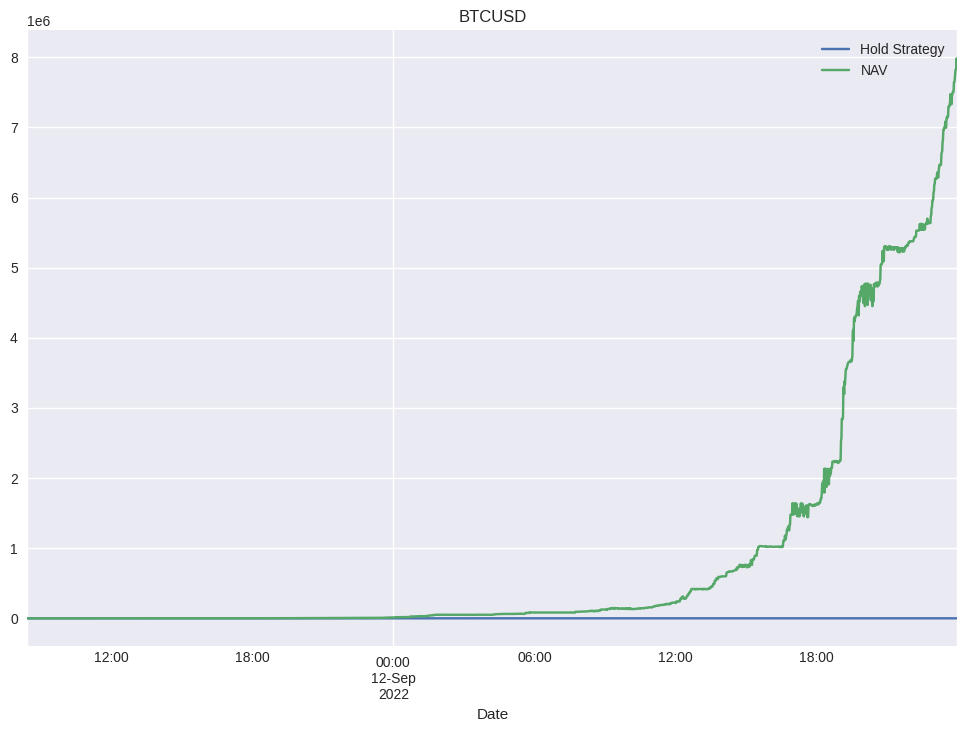

In [28]:
bc.plot_data(["Hold Strategy", "NAV"])

In [29]:
bc.data #with new columns!!

,price,returns,Hold Strategy,price|SMA|50,price|SMA|200,price|EWMA|2,price|EWMA|5,price|BBs|1|50|Lower,price|BBs|1|50|Upper,price|BBs|1|50|Distance,Position,NAV
Date,,,,,,,,,,,,
2022-09-11 08:27:00,21386.8,-0.005279,24.804803,21394.928,21444.3735,21412.817141,21405.853781,21298.666201,21491.189799,-8.128,0,2.500000e+01
2022-09-11 08:28:00,21250.0,-0.006417,24.646139,21391.228,21442.8480,21331.408570,21281.170756,21293.002497,21489.453503,-141.228,1,2.498001e+01
2022-09-11 08:29:00,21488.1,0.011142,24.922292,21392.190,21442.5075,21409.754285,21446.714151,21293.244187,21491.135813,95.910,-1,2.513894e+01
2022-09-11 08:30:00,21500.0,0.000554,24.936094,21393.490,21442.1630,21454.877143,21489.342830,21293.548259,21493.431741,106.510,-1,2.505525e+01
2022-09-11 08:31:00,21500.0,0.000000,24.936094,21395.492,21441.7840,21477.438571,21497.868566,21294.423008,21496.560992,104.508,-1,2.505525e+01
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-12 23:55:00,22060.0,0.000898,25.585592,22128.796,22151.8050,22072.151034,22059.597017,22051.701161,22205.890839,-68.796,1,7.826286e+06
2022-09-12 23:56:00,22199.8,0.006317,25.747735,22130.812,22151.8730,22135.975517,22171.759403,22053.196036,22208.427964,68.988,-1,7.859921e+06
2022-09-12 23:57:00,22060.0,-0.006317,25.585592,22131.726,22150.6275,22097.987758,22082.351881,22055.249356,22208.202644,-71.726,-1,7.985516e+06


### Testing buying and selling instrument by amount

In [30]:
#put fees false to make calculations simpler
bc = IterativeBacktest(
    symbol = "BTCUSD", 
    start = "2022-09-11", 
    end = "2022-09-12", #take care of the length of period!! It will help to make tests faster 
    amount = 25, #Less amount means make tests faster
    use_fee= True,
    fee_maker = 0.0002,
    fee_taker = 0.0004,
    csv = "data/btc-usdt_1m.csv"
)

In [31]:
#prints first period price
bc.data.price[0]

21555.1

In [32]:
#make the next period double of that to test it easier
bc.data.price[1] = bc.data.price[0]*2
bc.data.price[1]

43110.2

In [33]:
#put the leverage that you want
bc.leverage = 2

In [34]:
#available balance as declared on bc
bc.available_balance

25

In [35]:
#nav = Net Asset Value. Its the sum of your balance and current position. You dont have positions right now
#must be same as bc.available_balance
bc.get_nav(0)

25

In [36]:
#max amount of money you can spend is your available_balance times leverage
#Important: to spend a certain amount you should do:
#amount_for_function = amount_to_spend*leverage
max_amount = bc.available_balance*bc.leverage
max_amount

50

In [37]:
#buy max amount of units permitted at certain price
bc.buy_instrument(bar = 0, amount = abs(max_amount))

2022-09-11 |  Buying 0.002317782426173874 for 21555.1, leverage 2


In [38]:
#must be 0, because you spent all your money buying units
bc.available_balance

0.0

In [39]:
#opened positions are saved on this array
bc.open_orders

[LONG]

In [40]:
#you can get again the previous bought amount multiplying your units by buy price
# if fees are true, it will be a little less because opening position fee was paid
order = bc.open_orders[0]
amount = order.units*bc.data.price[0]
amount

49.96003197442047

In [41]:
#nav at time of buy, it must be the same as before buying
#if fee is True it will be less than cell above, because this takes into account the closing position fee
bc.get_nav(0)

24.960031974420467

In [42]:
#nav if we sell at the next period, it must consider leverage profits (and fees)
bc.get_nav(1)

74.90007993605117

In [43]:
#to sell all the units bought using "amount" you need to consider this: 
#The amount that you have changes when price moves, because you have units of the instrument!!!!!
#the current amount to sell is the total of units you have multiplied by the current price.
available_amount = bc.open_orders[0].units*bc.data.price[1]
available_amount

99.92006394884093

In [44]:
#MUST VERIFY THAT SELLS ALL BOUGHT UNITS
bc.sell_instrument(1, amount = abs(available_amount) )

2022-09-11 |  Selling (closing) 0.002317782426173874 for 43110.2


In [45]:
#must be same as predicted in bc.get_nav(1)
bc.available_balance

74.90007993605117

In [475]:
#must be same as bc.available_balance (2 cells above) because now you dont have open positions
bc.get_nav(1)

199800.15987210232

In [46]:
#must have now no open orders
bc.open_orders

[]

In [47]:
#closed orders are saved on this array
bc.closed_orders

[LONG]

In [48]:
#you can see the opening paid fee of the order
bc.closed_orders[0].opening_fee_as_amount

0.019984012789768187

In [49]:
#you can see the closing paid fee of the order
bc.closed_orders[0].closing_fee_as_amount

0.039968025579536375

# Using technical indicator classes
We can make a backtest straegy using a technical indicator class, this makes code cleaner. We will use SMA as an example, but you can find all available TIs on Technical Indicators notebook

In [21]:
class SMA():
    
    def __init__(self, data, SMA_S, SMA_L, column):
        self.data = data # Dataframe
        self.SMA_S = SMA_S # short SMA
        self.SMA_L = SMA_L # long SMA
        self.column = column # column to use SMA
        self.data["SMA_S"] = np.nan
        self.data["SMA_L"] = np.nan
        
    def calculate(self): #calculate for all dataframe
        self.data["SMA_S"] = self.data[self.column].rolling(self.SMA_S).mean()
        self.data["SMA_L"] = self.data[self.column].rolling(self.SMA_L).mean()
        #DONT DROP NA BECAUSE OTHER INDICATORS NEED THAT ROWS!!!
    
    def calculate_for_last_row(self): #calculate just for last row
        self.data["SMA_S"].iloc[-self.SMA_S:] = self.data[self.column].iloc[-self.SMA_S:].rolling(self.SMA_S).mean()
        self.data["SMA_L"].iloc[-self.SMA_L:] = self.data[self.column].iloc[-self.SMA_L:].rolling(self.SMA_L).mean()
    
    def strategy1(self, row):
        '''Returns predicted position (1,0 or -1)'''
        if self.data["SMA_S"].iloc[row] > self.data["SMA_L"].iloc[row]: # signal to go long
            return 1
        elif self.data["SMA_S"].iloc[row] < self.data["SMA_L"].iloc[row]: # signal to go short
            return -1
        else:
            return 0

In [22]:
class IterativeBacktest(BinanceApi):

    # helper method
    def go_long(self, bar, units = None, amount = None):
        if self.get_position() != 0:
            self.go_neutral(bar) #if some position, go neutral first
            if self.should_end_session(): return
        if units:
            self.buy_instrument(bar, units = units)
        elif amount:
            if amount == "all":
                amount = self.available_balance * self.leverage
            amount = self.validate_order_amount(amount, self.leverage)
            self.buy_instrument(bar, amount = amount) # go long

    # helper method
    def go_short(self, bar, units = None, amount = None):
        if self.get_position() != 0:
            self.go_neutral(bar) # if some position, go neutral first
            if self.should_end_session(): return
        if units:
            self.sell_instrument(bar, units = units)
        elif amount:
            if amount == "all":
                amount = self.available_balance * self.leverage
            amount = self.validate_order_amount(amount, self.leverage)
            self.sell_instrument(bar, amount = amount) # go short
    
    def go_neutral(self, bar):
        if self.get_position() == 1: #if long, sell all
            self.sell_instrument(bar, units = self.open_orders[0].units)
        elif self.get_position() == -1: #if short, buy all
            self.buy_instrument(bar, units = self.open_orders[0].units)
            
    def calculate_metrics(self, bar):
        if not self.keep_metrics: return
        self.positions.append( self.get_position() )
        self.navs.append( self.get_nav(bar) )
        
    def add_metrics_to_data(self):
        if not self.keep_metrics: return
        self.data["Position"] = self.positions + [0]*( self.data.shape[0] - len(self.positions) )
        self.data["NAV"] = self.navs + [0]*( self.data.shape[0] - len(self.positions) )
        
    def close_final_position(self, bar):
        date, price = self.get_values(bar)
        print(75 * "-")
        print("{} | +++ CLOSING FINAL POSITION +++".format(date))
        if self.get_position() in [-1]:
            self.buy_instrument(bar, units = self.open_orders[0].units)
        elif self.get_position() in [1]:    
            self.sell_instrument(bar, units = self.open_orders[0].units)
        perf = (self.available_balance - self.initial_balance) / self.initial_balance * 100
        self.print_available_balance(bar)
        print("{} | net performance (%) = {}".format(date, round(perf, 2) ))
        print("{} | number of trades executed = {}".format(date, self.trades)) 
        print("{} | number of liquidated orders = {}".format(date, self.liquidated_orders))
        print("{} | Amount spent on fee = {} ({}% of initial balance)".format(
            date, self.paid_fees, round(self.paid_fees/self.initial_balance*100, 2))
             ) 
        print(75 * "-")    
    
    def should_end_session(self):
        return abs(self.available_balance) < 0.1 and self.get_position() == 0 #no money and no positions
        
    def test_sma_strategy(self, SMA_S, SMA_L, leverage = 1,keep_metrics = True):
        
        # nice printout
        stm = "Testing SMA strategy | {} | SMA_S = {} & SMA_L = {}".format(self.symbol, SMA_S, SMA_L)
        print("-" * 75)
        print(stm)
        print("-" * 75)
        
        # reset 
        self.trades = 0  # no trades yet
        self.available_balance = self.initial_balance  # reset initial capital
        self.get_data() # reset dataset
        self.open_orders = []
        self.closed_orders = []
        self.paid_fees = 0
        self.liquidated_orders = 0
        self.leverage = leverage
        
        # prepare data
        sma = SMA(
            data = self.data,
            SMA_S = 50,
            SMA_L = 200,
            column = "price"
             )
        sma.calculate() #add columns to data
        
        self.data.dropna(inplace = True) #dropna after calculating the strategy
        
        #prepare metrics
        self.keep_metrics = keep_metrics
        self.positions, self.navs = [], []

        for bar in range(len(self.data)-1): # all bars (except the last bar)
            #date, price = self.get_values(bar) #useful to get current date and price
            self.verify_not_liquidation(bar) #verify current order isnt liquidated
            if self.should_end_session(): break #check if should end session  
            ############### Algorithm ############### 
            position = sma.strategy1(bar)
            if position == 1 and self.get_position() in [0, -1]:
                self.go_long(bar, amount = "all") # go long with full amount
            if position == -1 and self.get_position() in [0, 1]:
                self.go_short(bar, amount = "all") # go short with full amount
            ############## End Algorithm ############        
            self.calculate_metrics(bar)
            
        self.verify_not_liquidation(bar+1)           
        self.close_final_position(bar+1) # close the final open position
        self.calculate_metrics(bar+1)
        self.add_metrics_to_data()

In [23]:
bc = IterativeBacktest(
    symbol = "BTCUSD", 
    start = "2022-01-31", 
    end = "2023-06-30",
    amount = 100000, 
    use_fee= True,
    fee_maker = 0.0002,
    fee_taker = 0.0004
)

In [24]:
bc.test_sma_strategy(SMA_S = 50, SMA_L = 200, leverage = 1, keep_metrics = False)

---------------------------------------------------------------------------
Testing SMA strategy | BTCUSD | SMA_S = 50 & SMA_L = 200
---------------------------------------------------------------------------
2022-07-13 |  Selling 5.130732858735619 for 19482.6, leverage 1
2022-07-13 |  Buying (closing) 5.130732858735619 for 19830.9
2022-07-13 |  Buying 4.946546790932678 for 19830.9, leverage 1
2022-07-13 |  Selling (closing) 4.946546790932678 for 19605.6
2022-07-13 |  Selling 4.942591135762 for 19605.6, leverage 1
2022-07-13 |  Buying (closing) 4.942591135762 for 19740.0
2022-07-13 |  Buying 4.8713890963594295 for 19740.0, leverage 1
2022-07-14 |  Selling (closing) 4.8713890963594295 for 19748.5
2022-07-14 |  Selling 4.867493543303564 for 19748.5, leverage 1
2022-07-14 |  Buying (closing) 4.867493543303564 for 20199.8
2022-07-14 |  Buying 4.646277846908149 for 20199.8, leverage 1
2022-07-16 |  Selling (closing) 4.646277846908149 for 20690.8
2022-07-16 |  Selling 4.642562310845049 for 2

2022-08-02 |  Buying (closing) 2.8107944129827773 for 23949.0
2022-08-02 |  Buying 2.701571175342484 for 23949.0, leverage 1
2022-08-02 |  Selling (closing) 2.701571175342484 for 23264.0
2022-08-02 |  Selling 2.6994107825593234 for 23264.0, leverage 1
2022-08-02 |  Buying (closing) 2.6994107825593234 for 23513.1
2022-08-02 |  Buying 2.640102230532515 for 23513.1, leverage 1
2022-08-02 |  Selling (closing) 2.640102230532515 for 23268.9
2022-08-02 |  Selling 2.637990993243005 for 23268.9, leverage 1
2022-08-03 |  Buying (closing) 2.637990993243005 for 23588.7
2022-08-03 |  Buying 2.564410368212355 for 23588.7, leverage 1
2022-08-04 |  Selling (closing) 2.564410368212355 for 23844.0
2022-08-04 |  Selling 2.5623596602009897 for 23844.0, leverage 1
2022-08-05 |  Buying (closing) 2.5623596602009897 for 23148.3
2022-08-05 |  Buying 2.7142059605654874 for 23148.3, leverage 1
2022-08-05 |  Selling (closing) 2.7142059605654874 for 23018.0
2022-08-05 |  Selling 2.7120354639956634 for 23018.0, lev

# Optimizing the strategy
You can optimize an strategy trying different values for variables. In this case wi will find the best SMAs with the new function 'optimize_parameters'.

In [25]:
#this way we can make combinations with pairs of params to test them
#np.arange(inf, sup-1, step) makes list with numbers [inf, sup) with a separation "step"
#np.linspace(0, 10, num=4) makes list with numbers [inf, sup] with specified number of elements
#afer making lists, you use product to make all the combinations of all the lists
sma_s_range = np.arange(1, 50+1, 1)
sma_l_range = np.arange(51, 200+1, 1)
combinations = list(  product(  sma_s_range, sma_l_range  )  )
combinations

[(1, 51),
 (1, 52),
 (1, 53),
 (1, 54),
 (1, 55),
 (1, 56),
 (1, 57),
 (1, 58),
 (1, 59),
 (1, 60),
 (1, 61),
 (1, 62),
 (1, 63),
 (1, 64),
 (1, 65),
 (1, 66),
 (1, 67),
 (1, 68),
 (1, 69),
 (1, 70),
 (1, 71),
 (1, 72),
 (1, 73),
 (1, 74),
 (1, 75),
 (1, 76),
 (1, 77),
 (1, 78),
 (1, 79),
 (1, 80),
 (1, 81),
 (1, 82),
 (1, 83),
 (1, 84),
 (1, 85),
 (1, 86),
 (1, 87),
 (1, 88),
 (1, 89),
 (1, 90),
 (1, 91),
 (1, 92),
 (1, 93),
 (1, 94),
 (1, 95),
 (1, 96),
 (1, 97),
 (1, 98),
 (1, 99),
 (1, 100),
 (1, 101),
 (1, 102),
 (1, 103),
 (1, 104),
 (1, 105),
 (1, 106),
 (1, 107),
 (1, 108),
 (1, 109),
 (1, 110),
 (1, 111),
 (1, 112),
 (1, 113),
 (1, 114),
 (1, 115),
 (1, 116),
 (1, 117),
 (1, 118),
 (1, 119),
 (1, 120),
 (1, 121),
 (1, 122),
 (1, 123),
 (1, 124),
 (1, 125),
 (1, 126),
 (1, 127),
 (1, 128),
 (1, 129),
 (1, 130),
 (1, 131),
 (1, 132),
 (1, 133),
 (1, 134),
 (1, 135),
 (1, 136),
 (1, 137),
 (1, 138),
 (1, 139),
 (1, 140),
 (1, 141),
 (1, 142),
 (1, 143),
 (1, 144),
 (1, 145),
 (1,

In [26]:
class IterativeBacktest(BinanceApi):

    # helper method
    def go_long(self, bar, units = None, amount = None):
        if self.get_position() != 0:
            self.go_neutral(bar) #if some position, go neutral first
            if self.should_end_session(): return
        if units:
            self.buy_instrument(bar, units = units)
        elif amount:
            if amount == "all":
                amount = self.available_balance * self.leverage
            amount = self.validate_order_amount(amount, self.leverage)
            self.buy_instrument(bar, amount = amount) # go long

    # helper method
    def go_short(self, bar, units = None, amount = None):
        if self.get_position() != 0:
            self.go_neutral(bar) # if some position, go neutral first
            if self.should_end_session(): return
        if units:
            self.sell_instrument(bar, units = units)
        elif amount:
            if amount == "all":
                amount = self.available_balance * self.leverage
            amount = self.validate_order_amount(amount, self.leverage)
            self.sell_instrument(bar, amount = amount) # go short
    
    def go_neutral(self, bar):
        if self.get_position() == 1: #if long, sell all
            self.sell_instrument(bar, units = self.open_orders[0].units)
        elif self.get_position() == -1: #if short, buy all
            self.buy_instrument(bar, units = self.open_orders[0].units)
            
    def calculate_metrics(self, bar):
        if not self.keep_metrics: return
        self.positions.append( self.get_position() )
        self.navs.append( self.get_nav(bar) )
        
    def add_metrics_to_data(self):
        if not self.keep_metrics: return
        self.data["Position"] = self.positions + [0]*( self.data.shape[0] - len(self.positions) )
        self.data["NAV"] = self.navs + [0]*( self.data.shape[0] - len(self.positions) )
        
    def close_final_position(self, bar):
        date, price = self.get_values(bar)
        self.go_neutral(bar) # if some position, go neutral
        perf = (self.available_balance - self.initial_balance) / self.initial_balance * 100
        if self.verbose:
            self.print_available_balance(bar)
            print(75 * "-")
            print("{} | +++ CLOSING FINAL POSITION +++".format(date))
            print("{} | net performance (%) = {}".format(date, round(perf, 2) ))
            print("{} | number of trades executed = {}".format(date, self.trades)) 
            print("{} | number of liquidated orders = {}".format(date, self.liquidated_orders))
            print("{} | Amount spent on fee = {} ({}% of initial balance)".format(
            date, self.paid_fees, round(self.paid_fees/self.initial_balance*100, 2))
             ) 
            print(75 * "-")    
    
    def should_end_session(self):
        return self.available_balance < 0.1 and self.get_position() == 0 #no money and no positions
        
    def test_sma_strategy(self, SMA_S, SMA_L, leverage = 1,keep_metrics = True, verbose = True):
        self.verbose = verbose 
        if self.verbose:
            stm = "Testing SMA strategy | {} | SMA_S = {} & SMA_L = {}".format(self.symbol, SMA_S, SMA_L)
            print("-" * 75)
            print(stm)
            print("-" * 75)
        
        # reset 
        self.trades = 0  # no trades yet
        self.available_balance = self.initial_balance  # reset initial capital
        self.get_data() # reset dataset
        self.open_orders = []
        self.closed_orders = []
        self.paid_fees = 0
        self.liquidated_orders = 0
        self.leverage = leverage
        
        # prepare data
        sma = SMA(
            data = self.data,
            SMA_S = SMA_S,
            SMA_L = SMA_L,
            column = "price"
             )
        sma.calculate() #add columns to data
        
        self.data.dropna(inplace = True) #dropna after calculating the strategy
        
        #prepare metrics
        self.keep_metrics = keep_metrics
        self.positions, self.navs = [], []

        for bar in range(len(self.data)-1): # all bars (except the last bar)
            #date, price = self.get_values(bar) #useful to get current date and price
            self.verify_not_liquidation(bar) #verify current order isnt liquidated
            if self.should_end_session(): break #check if should end session  
            ############### Algorithm ############### 
            position = sma.strategy1(bar)
            if position == 1 and self.get_position() in [0, -1]:
                self.go_long(bar, amount = "all") # go long with full amount
            if position == -1 and self.get_position() in [0, 1]:
                self.go_short(bar, amount = "all") # go short with full amount
            ############## End Algorithm ############        
            self.calculate_metrics(bar)
            
        self.verify_not_liquidation(bar+1)           
        self.close_final_position(bar+1) # close the final open position
        self.calculate_metrics(bar+1)
        self.add_metrics_to_data()
        return round(self.available_balance, 1)
        
    def optimize_parameters(self, SMA_S_range, SMA_L_range):
        ''' Finds the optimal strategy (global maximum) given the SMA parameter ranges.

        Parameters
        ----------
        SMA_S_range, SMA_L_range: tuple
            tuples of the form (start, end, step size)
        '''
        sma_s_list = np.arange(*SMA_S_range)
        sma_l_list = np.arange(*SMA_L_range)
        combinations = list(product(
            sma_s_list, 
            sma_l_list
        ))
        
        # test all combinations
        results = []
        for comb in combinations:
            results.append(self.test_sma_strategy(
                SMA_S = comb[0], 
                SMA_L = comb[1], 
                leverage = 50, #higher leverage makes tests faster!
                keep_metrics = False, #False makes the process faster
                verbose = False #dont print order stuff
            ))
        
        best_perf = np.max(results) # best performance
        opt = combinations[np.argmax(results)] # optimal parameters
        
        # run/set the optimal strategy
        self.test_sma_strategy(
                SMA_S = opt[0], 
                SMA_L = opt[1], 
                leverage = 50,
                keep_metrics = True, #False makes the process faster
                verbose = False #dont print order stuff
            )
                   
        # create a df with many results
        many_results =  pd.DataFrame(data = combinations, columns = ["SMA_S", "SMA_L"])
        many_results["performance"] = results
        self.results_overview = many_results
                            
        return opt, best_perf    

In [30]:
bc = IterativeBacktest(
    symbol = "BTCUSD", 
    start = "2022-07-12", 
    end = "2022-07-19", #take care of the length of period!! It will help to make tests faster 
    amount = 100000, #Less amount means make tests faster
    use_fee= True,
    fee_maker = 0.0002,
    fee_taker = 0.0004
)

In [31]:
bc.optimize_parameters( 
        SMA_S_range = (40,40+2,1), 
        SMA_L_range = (150,150+2,1) 
    )

((40, 150), 0.0)

In [32]:
#Here you can see your results!
bc.results_overview

,SMA_S,SMA_L,performance
0,40,150,0.0
1,40,151,0.0
2,41,150,0.0
3,41,151,0.0
